In [1]:
import gym
import math
import os
import random
import gc
import copy
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from skimage import transform
import cv2
from PIL import Image


In [2]:
if not tf.test.is_gpu_available():
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


# DQN algo:

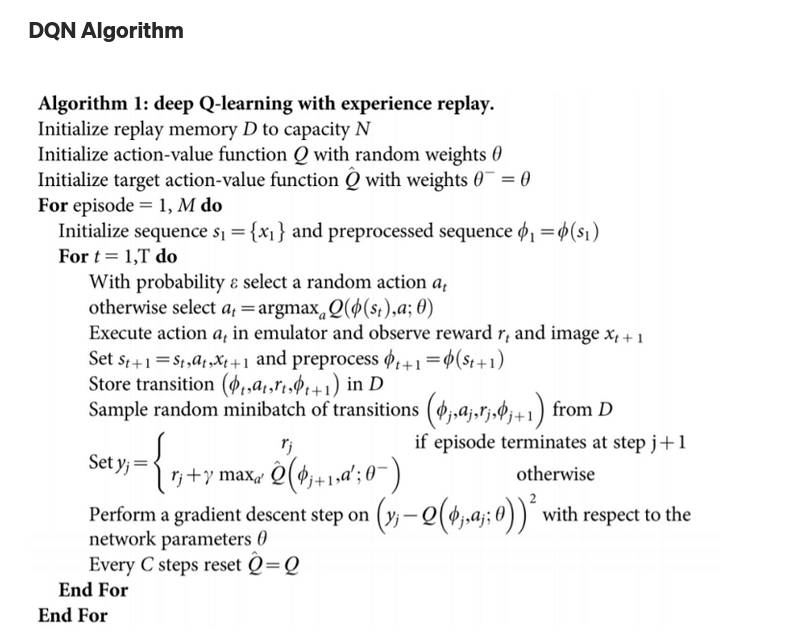

lets build objects in order  they appear on list

the paper itself:

https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [3]:
class replay_memory:
    """ 
    class that implements a not-yet-full buffer 
    repurposed a ring buffer rather than writing a replay memory using the examples that are not great with deque
    """
    def __init__(self,size_max = 10000): #max size suggested at 1k to 100k using 1k to limit samples to more recent ones
        self.max = size_max
        self.data = []

    class __Full:
        """ class that implements a full buffer """
        def remember(self, x):
            """ Append an element overwriting the oldest one. """
            self.data[self.cur] = x
            self.cur = (self.cur+1) % self.max
        def get_batch(self, n = 32): #batch size suggested at 64 to 512 samples
            indices = np.random.choice(len(self.data), n, replace=False)
            memories = [self.data[i] for i in indices]
            batch = [np.array(item) for item in zip(*memories)]
            return batch

    def remember(self,x):
        """append an element at the end of the buffer"""
        self.data.append(x)
        if len(self.data) == self.max:
            self.cur = 0
            # Permanently change self's class from non-full to full
            self.__class__ = self.__Full

    def get_batch(self, n = 32):
        """
        Get a sample of the replay buffer.
        Returns:
            A batch of observations in the form of
            [[states], [actions], [rewards], [dones], [next states]]
        """
        indices = np.random.choice(len(self.data), n, replace=False)
        memories = [self.data[i] for i in indices]
        batch = [np.array(item) for item in zip(*memories)]
        return batch

    

In [4]:
class q_action_value_network:
    """
    q_action_value_network
    
    this is the action-value function approximator
    """
    
    def __init__(self, \
                 input_size = (4, 84, 84), \
                 output_size = 2, \
                 learning_rate = 0.0001): #suggest learn rate btw .001 and .0001
        """
        initialization
        input_size is the state size [110, 84, 4] represents 110 px x 84 px x 4 frames must be a tuple
        num_hidden_layers  is how many hidden layers will be used
        learning_rate is the learning rate for the adam optimizer
        gamma is the discount rate
        """
        self.input_size = input_size 
        self.output = output_size
        self.learning_rate = learning_rate
        self.model = self.build_model()
    
    def build_model(self):
        """
        function to build the model based on passed inputs
        adjusted to mirror nature model
        """
        #init sequential
        q_net = tf.keras.Sequential()
        
        #add conv layers
        q_net.add(tf.keras.layers.Conv2D(input_shape = self.input_size, filters=32 , kernel_size=(8,8), 
                                         strides = (4,4)))
                         
        q_net.add(tf.keras.layers.Conv2D(filters=64 , kernel_size=(4,4), strides = (2,2)))

        q_net.add(tf.keras.layers.Conv2D(filters=64 , kernel_size=(3,3), strides = (1,1)))       
       
        q_net.add(tf.keras.layers.Flatten())
        
        #add connected layers
        q_net.add(tf.keras.layers.Dense(512, activation='relu'))

        q_net.add(tf.keras.layers.Dense(self.output))
        
        #compile
        q_net.compile(optimizer=tf.optimizers.Adam(learning_rate=self.learning_rate),
                      loss='mse')
        
        return q_net
    
    def train_model(self, states, targets):
        """
        function to train model

        """            
        #print(states)
        #print(targets)
        result = self.model.fit(x = states, y = targets, verbose = 0, batch_size = 32)
        
        keras.backend.clear_session() 
        return result.history['loss'][0]
    

In [5]:
from collections import deque
import cv2
import gym
import numpy as np

#wrappers matching this version here:
#https://github.com/openai/gym/tree/master/gym/wrappers

class gif_output(gym.Wrapper):
    def __init__(self, env, env_id):
        """
        wraps wrappers to orig env so it can get basee frames in forms of obs in orig color
        then dumps to a gif
        """
        gym.Wrapper.__init__(self, env)
        
        self.gif = env_id
        
        self.frames = []
    
    def process_and_apend(self, obs):
        
        image = Image.fromarray(obs.astype(np.uint8))
        
        self.frames.append(image) 
    
    def close_gif(self):
        
        self.frames[0].save(str(self.gif + '.gif'),
               save_all=True, append_images=self.frames[1:], optimize=False, duration=len(self.frames)//20, loop=0)
        
        print("gif created as: ", self.gif, ".gif")
    
    def reset(self, **kwargs):
        
        obs, info = self.env.reset(**kwargs)
        
        self.process_and_apend(obs)

        return obs, info

    def step(self, ac):
        obs, reward, done, truncated, info = self.env.step(ac)        

        self.process_and_apend(obs)
        
        if done:
            self.close_gif()
            
        return obs, reward, done, truncated, info
    
from collections import deque

from collections import deque

import cv2
import gym
import numpy as np


class AtariPreprocessor(gym.Wrapper):
    """
    gym wrapper for preprocessing atari frames.
    """

    def __init__(self, env, frame_skips=4, resize_shape=(84, 84), state_buffer_size=2):
        """
        Initialize preprocessing settings.
        Args:
            env: gym environment that returns states as atari frames.
            frame_skips: Number of frame skips to use per environment step.
            resize_shape: (m, n) output frame size.
            state_buffer_size: State buffer for max pooling.
        """
        super(AtariPreprocessor, self).__init__(env)
        self.skips = frame_skips
        self.frame_shape = resize_shape
        self.observation_space_shape = (*resize_shape, 1)
        self.observation_buffer = deque(maxlen=state_buffer_size)

    def process_frame(self, frame):
        """
        Resize and convert atari frame to grayscale.
        Args:
            frame: Image as numpy.ndarray

        Returns:
            Processed frame.
        """
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = cv2.resize(frame, self.frame_shape) / 255
        return np.expand_dims(frame, -1)

    def step(self, action: int):
        """
        Step respective to self.skips.
        Args:
            action: Action supported by self.env

        Returns:
            (state, reward, done, info)
            
        Taking the max here means the image will show a line for the ball as it travels 
        this will be similar to feeding in to the cnn a frame stack
        """
        total_reward = 0
        state, done, info = 3 * [None]
        for _ in range(self.skips):
            state, reward, done, truncated, info = self.env.step(action)
            total_reward += reward
            self.observation_buffer.append(state)
            if done:
                break
        max_frame = np.max(np.stack(self.observation_buffer), axis=0)
        return self.process_frame(max_frame), total_reward, done, truncated, info

    def reset(self, **kwargs):
        """
        Reset self.env
        Args:
            **kwargs: kwargs passed to self.env.reset()

        Returns:
            Processed atari frame.
        """
        self.observation_buffer.clear()
        observation, info = self.env.reset(**kwargs)
        self.observation_buffer.append(observation)
        return self.process_frame(observation), info



In [6]:
class agent_class:
    """
    agent class to contain replay buffer and q action value functions
    
    using PongNoFrameskip-v4    
    """
    
    def __init__(self, 
                 environment = 'PongNoFrameskip-v4', 
                 max_steps = 50000, 
                 check_ep = 50, 
                 c = 1000, #when to flip models
                 update_freq = 1, #how many steps to wait btw updates
                 learning_start = 10000, #equal to buffer size
                 epsilon = 0.0, 
                 gamma = 0.99): 
                 
        
        """
        init for agents
        
        environment defines which gym environment we will play
        c is the number of steps to flip the q and q hat networks
        """
        self.c = c # how many steps to flip models deep mind say 10k open ai 1k
        self.environment = environment
        self.env = gym.make(self.environment)
        self.env = gif_output(self.env, self.environment)
        self.env = AtariPreprocessor(self.env)
        self.max_steps = max_steps #max steps in episode , set at 200 to emulate original cart pole env v0
        self.check_ep = check_ep # how many episdoes to print telemetry
        self.epsilon = epsilon #explore/exploit, should do an eps decay function to start with high explore to help learn
        self.initial_epsilon = epsilon #initial eps
        self.gamma = gamma
        self.update_freq = update_freq #how many steps between retraining neural net
        self.learning_start = learning_start
        self.input_shape = self.env.observation_space_shape #this is forced since we know we are manipulating the output and what that will be
        self.actions = self.env.action_space.n
        self.batch_size = 32
        self.replay_buffer = replay_memory() #while technically a ring buffer the return function gives unordered results
        self.eps_decay_type = 0 #0 = linear, 1 = sigmoid looking
        
        #build networks        
        #target
        self.q = q_action_value_network(input_size = self.input_shape , output_size = self.actions)
        
        #q hat
        self.q_hat = q_action_value_network(input_size = self.input_shape , output_size = self.actions)
        
        self.losses = []
        
    def policy(self, state, train):
        """
        select action to take

        """
        optimal = 0
        if (np.random.rand() <= self.epsilon and train) or train == 0:
            optimal = 1
            
            #check if state is numpy
            if type(state).__module__ != 'numpy':
                state_stack = np.array(state)
                                       
            #if random is less than the exploit prob
            #get max action                
            prediction = self.q.model.predict(state[None,:], verbose = 0)

            action = np.argmax(prediction[0])         
            
        else:
            #select non max action
            action = np.random.choice([x for x in range(self.actions)]) 
            
            #applied knowledge of game where noobs, right, left are that do anything with pong
            # action = np.random.choice([0,2,3]) 
            
        keras.backend.clear_session() 
        return action, optimal

    def q_training(self):
        """
        trains q model used for chosing actions
        #sample from buffer                     
        #replay_buffer is to pass the replay buffer to sample from
        #our replay retuns a list of lists in the format
        #[state, next_state, action, reward, done]
        
        """
        
        states, new_states, actions, rewards, dones  = self.replay_buffer.get_batch(n = self.batch_size)
        q_states = self.q.model.predict(states, verbose = 0)
        new_state_values = self.q_hat.model.predict(new_states, verbose = 0).max(1)
        new_state_values[dones] = 0
        target_values = np.copy(q_states)
        target_values[np.arange(self.batch_size), actions] = (
            new_state_values * self.gamma + rewards
        )

        error = self.q.train_model(states, target_values)

        self.losses.append(error)
        keras.backend.clear_session() 

        
    def epsilon_decay(self, c_steps):
        """
        decays epsilon
        """
        final_epsilon = 0.98
        epsilon_decay = 80000
        if self.eps_decay_type:
            self.epsilon = final_epsilon - ((final_epsilon - self.initial_epsilon) * math.exp(-1. * c_steps / epsilon_decay))
        else:        
            self.epsilon = min(final_epsilon, 0 + c_steps / epsilon_decay)
                        
    def run_episodes(self,
                     n = 10000,
                     train = 1,
                     render = 0):
        """
        run episodes
        
        n = number of episodes to run
        train = training or pure exploitation
        """
        complete_scores = []
        self.losses = []
        c_steps = 0   
        max_score = -22
        avg_max_score = -22
        breaker = 1
        i = 0
        
        
        if train == 0 and render:
            self.env = gym.make(self.environment)
            self.env = gif_output(self.env, self.environment)
            self.env = AtariPreprocessor(self.env)
        else:
            self.env = gym.make(self.environment)
            self.env = AtariPreprocessor(self.env)
        
        while breaker:
            i += 1
            score = 0
            steps = 0
            actions = []
            optimals = []  
            rewards = []
           
            state = self.env.reset()[0]
           
            while True:
                
                c_steps += 1
                steps += 1
                
                action, optimal = self.policy(state, train)
                
                next_state, reward, done, truncated, info = self.env.step(action)
                
                #max steps an episode is allowed to run
                if steps >= self.max_steps:
                    done = 1             

                if train:
                    self.replay_buffer.remember([state, next_state, action, reward, done]) 
                    
                    if c_steps > self.learning_start and c_steps % self.update_freq == 0:
                        #update action selection model
                        self.q_training()

                    if c_steps > self.learning_start + self.c and c_steps % self.c == 0:
                        #print("flip model weights")
                        self.q_hat.model.set_weights(self.q.model.get_weights()) 

                    if c_steps - self.learning_start > 0:
                        self.epsilon_decay(c_steps - self.learning_start)   
                
                state = next_state
                rewards.append(reward)
                actions.append(action)
                optimals.append(optimal)
                score += reward
                
                if done:                    
                    complete_scores.append(score)
                    if len(complete_scores) < 20 or len(complete_scores) % 20 == 0:
                        print("episode ", len(complete_scores), \
                              " score ",  score, \
                              " avg score (convergence check)", round(np.mean(complete_scores[-self.check_ep//2:]),2), \
                              " steps ", c_steps, \
                              " epsilon " , round(self.epsilon,4))
                        
                    if max_score < score:
                        max_score = score
                        print("new max score attained:", score, " on episode:", len(complete_scores)) 
                        print("avg score over last ", min(self.check_ep, len(complete_scores)) , " run(s):", \
                              round(np.mean(complete_scores[-self.check_ep:]),2))
                        print("total steps observed in env thru all episodes:", c_steps)
                        
                    if avg_max_score < round(np.mean(complete_scores[-self.check_ep//2:]),2):
                        avg_max_score = round(np.mean(complete_scores[-self.check_ep//2:]),2)
                        print("new average max score attained:", avg_max_score, " on episode:", len(complete_scores)) 
                        print("total steps observed in env thru all episodes:", c_steps)                      
                        
                        if c_steps > 100000:
                            # save model weights
                            self.q.model.save_weights('model_weights' + self.environment + '_step_' + str(c_steps))
                        
                        
                    if train:
                        #early stopping/exit if score is mean 18 or greater over prior check episodes // 2
                        #using 18 as early stopping as that is still consistently winning.
                        # we can tweak to try faster implementations later but tf is dreadfully slow on my system
                        if len(complete_scores) >= 20 and round(np.mean(complete_scores[-self.check_ep//2:]),2) >= 18:
                            print("convergence has been attained")
                            print("total steps observed in env thru all episodes:", c_steps)
                            print("current epsilon:", self.epsilon)
                            print("max score attained :", max(complete_scores))
                            print("total completed episodes:", len(complete_scores))
                            print("mean score over prior " , self.check_ep//2 , " steps :", round(np.mean(complete_scores[-self.check_ep//2:]),2) )
                            breaker = 0 #break whole loop
                            
                            # save model weights
                            self.q.model.save_weights('converged_model_weights_' + self.environment)

                            break

                        if len(complete_scores) % self.check_ep == 0:
                            gc.collect()
                            print("episode:", i + 1, "score: ", score)
                            print("avg score over last ", min(self.check_ep, len(complete_scores)) , " run(s):", \
                                  round(np.mean(complete_scores[-self.check_ep:]),2))
                            print("max score attained :", max(complete_scores))
                            print("max score attained over last", min(self.check_ep, len(complete_scores)),\
                                  " runs :", max(complete_scores[-self.check_ep:]))
                            print("total steps observed in env thru all episodes:", c_steps)
                            print("current epsilon:", self.epsilon)
                            print("last 10 actions: " , actions[-10:])
                            print("last 10 optimals: ", optimals[-10:])
                            print("last 10 rewards: ", rewards[-10:])
                            if c_steps > self.learning_start:
                                print("last loss:" , self.losses[-1])
                                
                    if i >= n:
                        breaker = 0
                                
                    break
         
        #when complete plot results        
        self.env.close()
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), sharey=False)
        ax1.plot(np.arange(len(complete_scores)), complete_scores)
        ax1.set_title('Total Scores Over Episodes')
        ax1.set_ylabel('Score')
        ax2.plot(np.arange(len(self.losses)), self.losses)
        ax2.set_title('Losses Over Training Steps')
        ax2.set_ylabel('Loss')
        plt.show()            
       

In [7]:
agent = agent_class()


episode  1  score  -21.0  avg score (convergence check) -21.0  steps  946  epsilon  0.0
new max score attained: -21.0  on episode: 1
avg score over last  1  run(s): -21.0
total steps observed in env thru all episodes: 946
new average max score attained: -21.0  on episode: 1
total steps observed in env thru all episodes: 946
episode  2  score  -21.0  avg score (convergence check) -21.0  steps  1875  epsilon  0.0
episode  3  score  -19.0  avg score (convergence check) -20.33  steps  2902  epsilon  0.0
new max score attained: -19.0  on episode: 3
avg score over last  3  run(s): -20.33
total steps observed in env thru all episodes: 2902
new average max score attained: -20.33  on episode: 3
total steps observed in env thru all episodes: 2902
episode  4  score  -20.0  avg score (convergence check) -20.25  steps  3804  epsilon  0.0
new average max score attained: -20.25  on episode: 4
total steps observed in env thru all episodes: 3804
episode  5  score  -21.0  avg score (convergence check) -

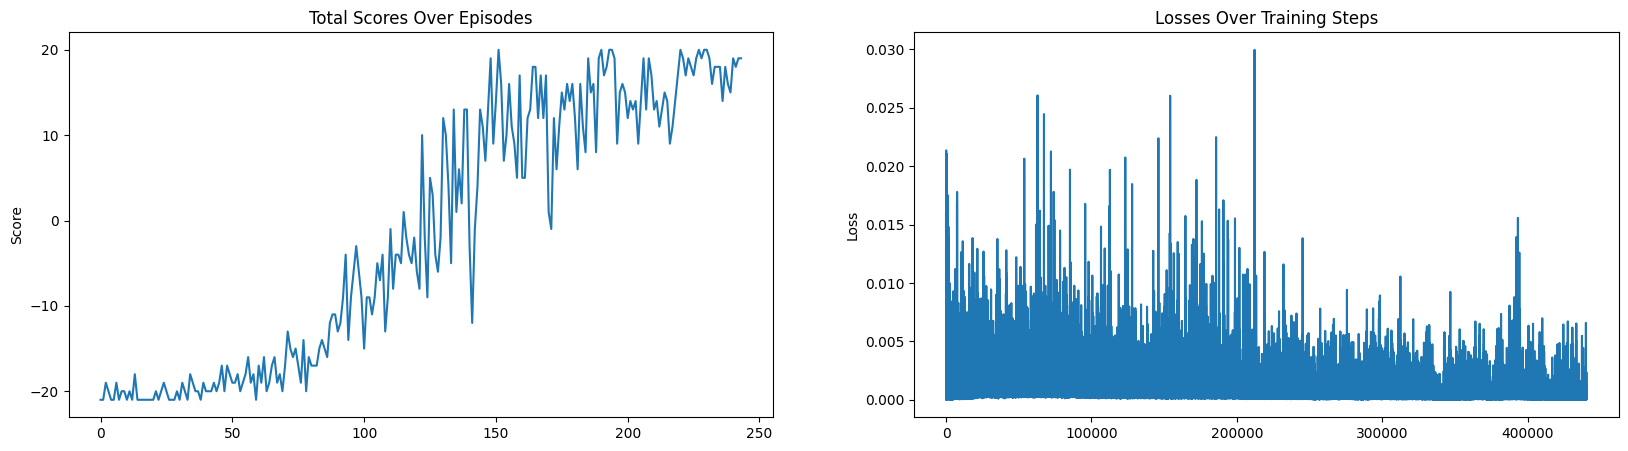

In [8]:
agent.run_episodes(n = 550)


episode  1  score  19.0  avg score (convergence check) 19.0  steps  1774  epsilon  0.98
new max score attained: 19.0  on episode: 1
avg score over last  1  run(s): 19.0
total steps observed in env thru all episodes: 1774
new average max score attained: 19.0  on episode: 1
total steps observed in env thru all episodes: 1774
episode  2  score  19.0  avg score (convergence check) 19.0  steps  3548  epsilon  0.98
episode  3  score  19.0  avg score (convergence check) 19.0  steps  5322  epsilon  0.98
episode  4  score  19.0  avg score (convergence check) 19.0  steps  7096  epsilon  0.98
episode  5  score  19.0  avg score (convergence check) 19.0  steps  8870  epsilon  0.98
episode  6  score  19.0  avg score (convergence check) 19.0  steps  10644  epsilon  0.98
episode  7  score  19.0  avg score (convergence check) 19.0  steps  12418  epsilon  0.98
episode  8  score  19.0  avg score (convergence check) 19.0  steps  14192  epsilon  0.98
episode  9  score  19.0  avg score (convergence check) 1

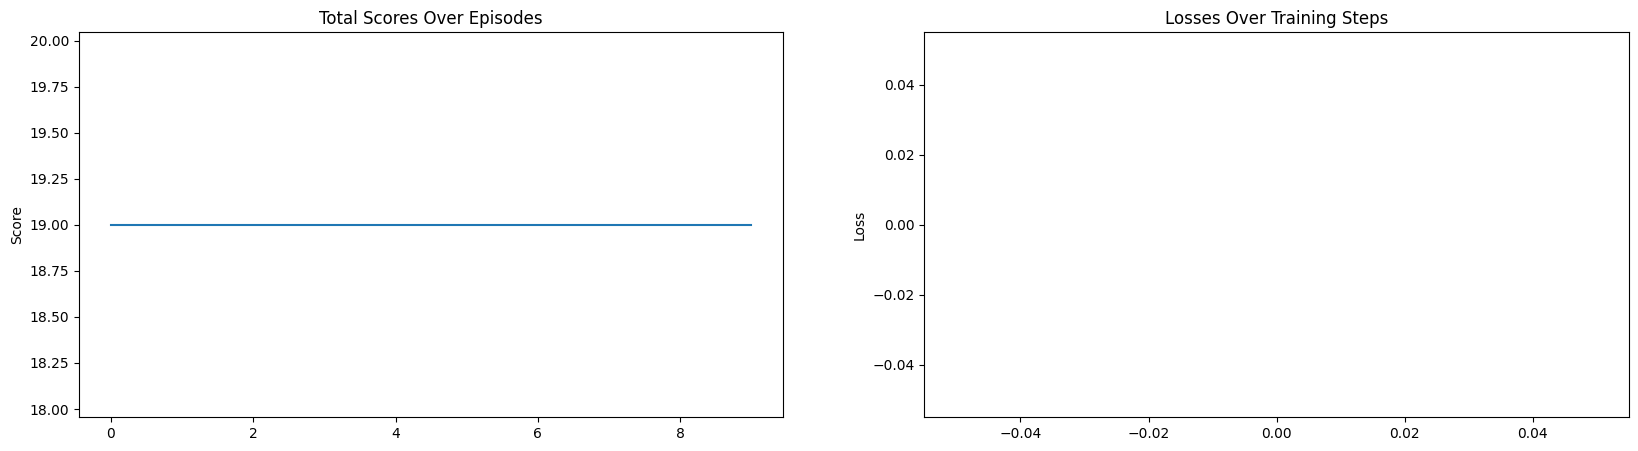

In [9]:
agent.run_episodes(n = 10, train = 0)


gif created as:  PongNoFrameskip-v4 .gif
episode  1  score  19.0  avg score (convergence check) 19.0  steps  1774  epsilon  0.98
new max score attained: 19.0  on episode: 1
avg score over last  1  run(s): 19.0
total steps observed in env thru all episodes: 1774
new average max score attained: 19.0  on episode: 1
total steps observed in env thru all episodes: 1774


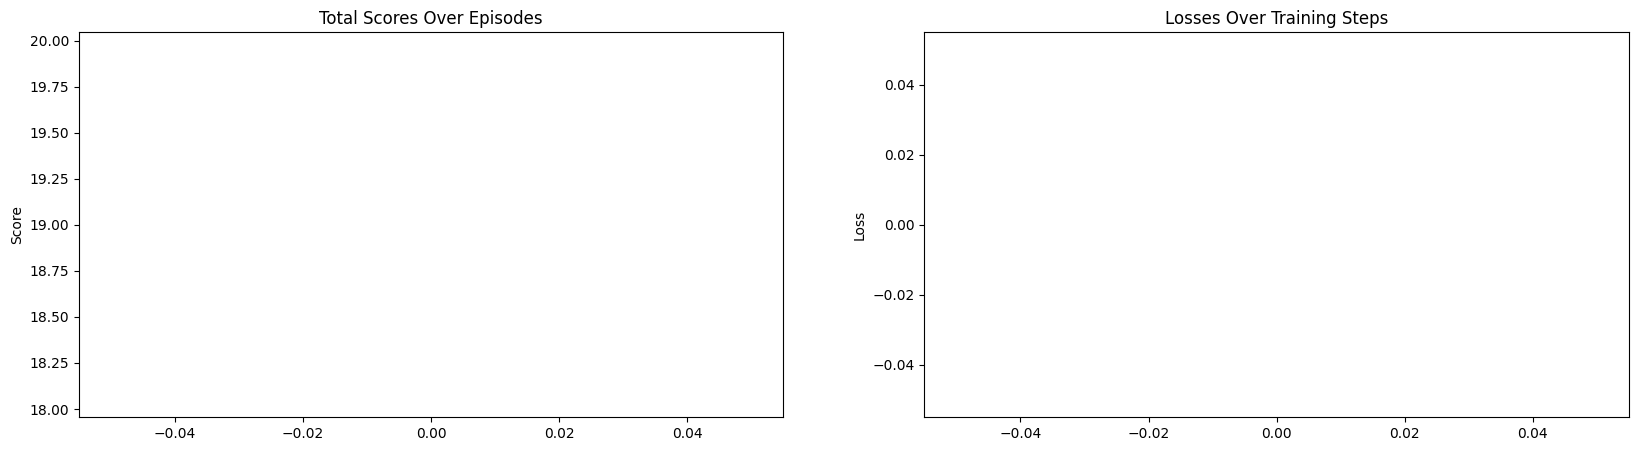

In [10]:
#render out avi of agent performing as well as a gif...
agent.run_episodes(n = 1, train = 0, render = 1)


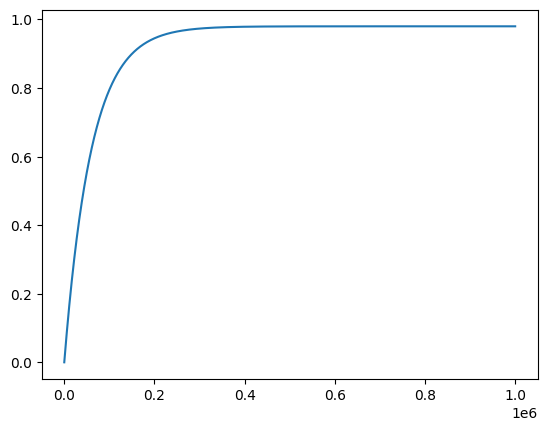

In [11]:
#show epsilon increase over steps
#explore decay where epsilon is how much exploit 
import numpy as np
import math

dummy_list = []
initial_epsilon = .0
final_epsilon = 0.98
epsilon_decay = 60000
epsilon = initial_epsilon

for c_steps in range(1000000):
    epsilon = final_epsilon - ((final_epsilon - initial_epsilon) * math.exp(-1. * c_steps / epsilon_decay))
    
    dummy_list.append(epsilon)
    
import matplotlib.pyplot as plt

#plot decay curve to show how it changes over the cumulative steps taken
plt.plot(np.arange(len(dummy_list)), dummy_list)

plt.show()


## agent performance

![pong_agent_performance](https://media.giphy.com/media/vFKqnCdLPNOKc/giphy.gif)

![pong_agent_performance](https://github.com/jnesfield/Reinforcement-Learning/blob/main/function%20approximation%201/PongNoFrameskip-v4-2.gif?raw=true)